In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime

In [8]:
#Read the csv file
df = pd.read_csv('GE.csv')
train_dates = pd.to_datetime(df['Date'])


In [9]:
#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [10]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

In [11]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [12]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1748, 14, 5).
trainY shape == (1748, 1).


In [13]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 14, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.1847 - val_loss: 0.1025
Epoch 2/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0302 - val_loss: 0.0378
Epoch 3/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0236 - val_loss: 0.0255
Epoch 4/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0240 - val_loss: 0.0167
Epoch 5/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0221 - val_loss: 0.0193


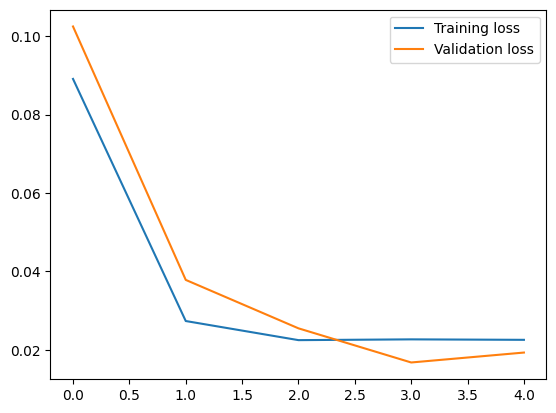

In [14]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [15]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2024-04-09 00:00:00'), Timestamp('2024-04-10 00:00:00'), Timestamp('2024-04-11 00:00:00'), Timestamp('2024-04-12 00:00:00'), Timestamp('2024-04-15 00:00:00'), Timestamp('2024-04-16 00:00:00'), Timestamp('2024-04-17 00:00:00'), Timestamp('2024-04-18 00:00:00'), Timestamp('2024-04-19 00:00:00'), Timestamp('2024-04-22 00:00:00'), Timestamp('2024-04-23 00:00:00'), Timestamp('2024-04-24 00:00:00'), Timestamp('2024-04-25 00:00:00'), Timestamp('2024-04-26 00:00:00'), Timestamp('2024-04-29 00:00:00')]


In [16]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [17]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

C:\Users\victo\AppData\Local\Temp\ipykernel_38608\788859048.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


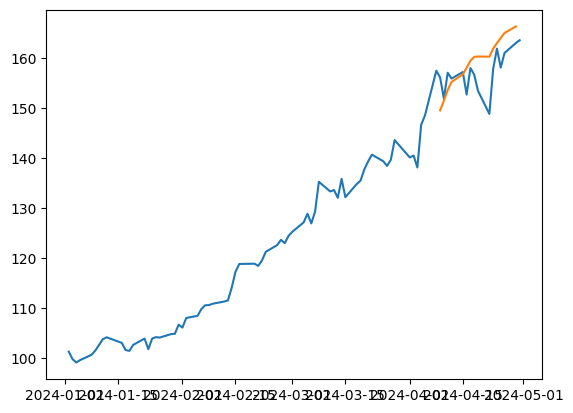

In [21]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2024-1-1']

plt.plot(original['Date'], original['Open'])
plt.plot(df_forecast['Date'], df_forecast['Open'])

In [31]:
mse = mean_squared_error(filtered_original['Open'], df_forecast['Open'])
print("Mean Squared Error:", mse)

merged_data = original.merge(df_forecast, on='Date', how='inner')

Mean Squared Error: 23.81345777424219


In [30]:
filtered_original = original[original['Date'].isin(df_forecast['Date'])]
print(filtered_original)


           Date        Open
1746 2024-04-09  156.130005
1747 2024-04-10  151.889999
1748 2024-04-11  157.070007
1749 2024-04-12  155.899994
1750 2024-04-15  157.199997
1751 2024-04-16  152.699997
1752 2024-04-17  158.000000
1753 2024-04-18  156.679993
1754 2024-04-19  153.449997
1755 2024-04-22  148.830002
1756 2024-04-23  157.830002
1757 2024-04-24  161.869995
1758 2024-04-25  158.089996
1759 2024-04-26  161.009995
1760 2024-04-29  163.000000


In [32]:
from sklearn.metrics import mean_squared_error

# Select the original 'Open' values for the forecasted period

# Calculate Mean Squared Error
mse = mean_squared_error(filtered_original['Open'], df_forecast['Open'])
print("Mean Squared Error:", mse)

# Optionally, you can also calculate and print other error metrics like MAE or RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(filtered_original['Open'], df_forecast['Open'])
print("Mean Absolute Error:", mae)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)


Mean Squared Error: 23.81345777424219
Mean Absolute Error: 3.9109913313802074
Root Mean Squared Error: 4.879903459520709
